In [314]:
import numpy as np
from matplotlib import pyplot as plt

# Determines verticle velocity eqn of the plinko
def velocityY(vY, t):
    return (-981  - (0.5 * vY**2)) * t

def velocityX(vX, t):
    return -0.5 * vX**2 * t

#def psn(initial, velocityY, velocityX):

# Function the create peg Locations depending on size of the board
def InitializePegs(y, pegs, spacing, boardHeight, boardWidth):
    pegHeight, pegWidth = pegs.shape
    offset = spacing/2
    width1 = np.arange(offset, boardWidth + spacing, spacing)
    for i in range(0, np.size(width1)):
        if (width1[i] > boardWidth):
            width1[i] = None
    width2 = np.arange(0, boardWidth + spacing, spacing)
    alternate = 1;
    heightSpace = spacing * np.cos(30 * (np.pi/180))
    height = 0
    # Sets both the x and y positions for the pegs
    for i in range(0, pegHeight):
        for j in range(0, pegWidth):
            if (alternate % 2 != 0):
                pegs[i][j] = width1[j]
            else:
                pegs[i][j] = width2[j]
            y[i][j] = height
        alternate += 1
        height += heightSpace
    return y, pegs
    
# Draw Game Board
def drawBoard(height, width, spacing, numOfPegsInRows, numOfPegRows):
    boardHeight = height - 10
    pegsX = np.zeros((numOfPegsInRows + 1) * numOfPegRows).reshape(numOfPegRows, numOfPegsInRows + 1)
    pegsY = np.copy(pegsX)
    pegsY, pegsX = InitializePegs(pegsY, pegsX, spacing, boardHeight, width)
    plt.plot(pegsX, pegsY, "o", c='black', markersize = 1)
    return pegsX, pegsY



In [326]:
# Global variables to keep track of which variable a double array is pointing to
# i.e an x-coord or a y-coord
X = 0
Y = 1

def findTrajectory(plinko1, plinko2, NumOfPoints):
    points = np.zeros(NumOfPoints * 2).reshape(NumOfPoints, 2)
    pointsY = np.linspace(plinko1[Y], plinko2[Y], NumOfPoints)
    pointsX = np.linspace(plinko1[X], plinko2[X], NumOfPoints)
    points[:,Y] = pointsY
    points[:,X] = pointsX
    return np.copy(points)

# Predicts path of plinko through 100 points
# If any point touches a peg, the function acts as if it hit a peg at said point
# Kinda messes with the timeStep and does not seem any more accurate
# Honestly do not know how to stop the ball from passing through a peg without making the timeStep insanely slow
# Looked at the lectures and all of it is on random numbers, however this should be a perfect system
# The second part is about randomness which has not been added yet
# However the second part should slow down the plinko enough to make the errors less apparent
def predictive(plinko, v, plinkoDiam, pegDiam, timeStep, pegsX, pegsY):
    oldPlinko = np.copy(plinko)
    tempPlinko, v2 = movePlinko(plinko, v, timeStep)  
    NumOfPoints = 100
    projectedPath = findTrajectory(oldPlinko, tempPlinko, NumOfPoints)
    collision = None
    theta = None
    for i in range (0, NumOfPoints):
        theta = detectCollision(pegDiam, plinkoDiam, projectedPath[i,:], v, pegsX, pegsY)
        if (theta != None):
            collision = i
            break
    if (theta == None):
        v2 = bounceOffWall(tempPlinko, np.copy(v2))
        return tempPlinko, v2
    timeStepFraction = timeStep * (collision + 1)/NumOfPoints
    tempPlinko, v2 = movePlinko(oldPlinko, v2, timeStepFraction)
    v2[X], v2[Y] = collisionVelocity(v2[X], v2[Y], theta)
    plinko, v = movePlinko(tempPlinko, v2, timeStep - timeStepFraction)
    v = bounceOffWall(plinko, np.copy(v))
    return plinko, v

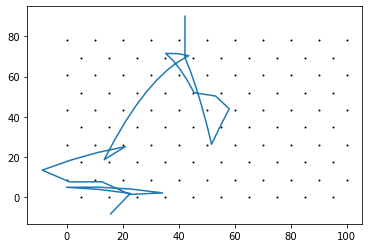

In [337]:
# Function to move Plinko
def movePlinko(plinko, v, timeStep):
    v[Y] += velocityY(v[Y], timeStep)
    v[X] += velocityX(v[X], timeStep)
    plinko[X] += v[X]
    plinko[Y] += v[Y]
    return plinko, v

# Helper function to determine the angle between 
def findTheta(pegX, pegY, plinko):
    rise = plinko[Y] - pegY
    run = plinko[X] - pegX
    #if (rise  < 0 and run < 0)
    theta = np.arctan(rise/run) * 180/np.pi
    return theta

# Defines distance of plinko from the peg
def findDistance(pegX, pegY, plinko):
    y = plinko[Y] - pegY
    x = plinko[X] - pegX
    length = x**2 + y**2
    return np.sqrt(length)

# Bounces off a make believe point 
def bounceOffWall(plinkoWall, vW):
    theta = None
    if (vW[X] < 0 and plinkoWall[X] < 0):
        vW[X] = -vW[X]
        return vW
    if (vW[X] > 0 and plinkoWall[X] > 100):
        vW[X] = -vW[X]
        return vW
    return vW

# Determines location of plinko collision and returns the angle of the collision
# Returns None if no collision is detected
# TODO: Collision detection does not work 100% of the time, needs to be tweaked
def detectCollision(pegDiam, plinkoDiam, plinko, v, pegsX, pegsY):
    pegHeight, pegWidth = np.shape(pegsY)
    plinkoRadius = plinkoDiam/2
    pegRadius = pegDiam/2
    error = plinkoRadius + pegRadius
    yLoc = None
    for i in range(0, pegHeight):
        if (plinko[Y] >= pegsY[i][0] - error and plinko[Y] <= pegsY[i][0] + error):
            yLoc = i
    if (yLoc == None):
        return None
    xLoc = None
    dist = 0
    distTemp = 0
    for j in range(0, pegWidth):
        distTemp = findDistance(pegsX[yLoc][j], pegsY[yLoc][0], plinko)
        if(distTemp <= error):
            if (distTemp >= dist):
                dist = distTemp
                xLoc = j
    if(xLoc == None):
        return None
    theta = findTheta(pegsX[yLoc][xLoc], pegsY[yLoc][xLoc], plinko)
    return theta

# Updates collision velocity
def collisionVelocity(xIn, yIn, theta):
    array1 = np.array([[np.cos(2*theta), np.sin(2*theta)], [np.sin(2*theta), -np.cos(2*theta)]])
    array2 = np.array([xIn, yIn])
    vX, vY = np.linalg.solve(array1, array2)
    return vX, vY
    

# Test function to simulate the movement of the plinko
# While somewhat works has an issue where it won't detect a peg if the time step is too large
# TODO: Add all necessary arguments
# TODO: Add randomness and energy loss
# TODO: Get ride of dividing by zero error
# It occurs when the ball hits a peg at pi/2, pi etc... radians
def PlinkoTest():
    originX = 42.3
    originY = 90
    plinko = np.array([originX, originY])
    plinkoPos = np.copy(plinko)
    pegsX, pegsY = drawBoard(90, 100, 10, 10, 10)
    v = np.zeros(2)
    while(plinkoPos[Y] > 0):
        theta = detectCollision(1, 5, plinkoPos, v, pegsX, pegsY)
        if (theta != None):
            v = collisionVelocity(v[X], v[Y], theta)
        v = bounceOffWall(plinkoPos, np.copy(v))
        plinkoPos, v = movePlinko(plinkoPos, np.copy(v), 0.001)
        plinko = np.vstack((plinko, plinkoPos))
    plt.plot(plinko[:,X], plinko[:,Y])
    plt.show()
PlinkoTest()



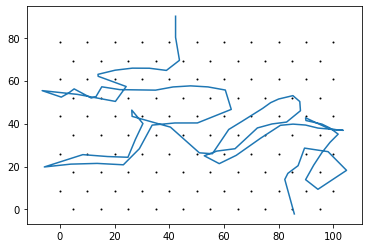

In [338]:
# Second Plinko Test using a trajectory calculating method
# Slightly more accurate but still not perfect
def PlinkoTest2():
    originX = 42.3
    originY = 90
    # Plinko is now a 2D array, it should be a class but they never taught us about classes in python so I decided against it
    plinko = np.array([originX, originY])
    plinkoPos = np.copy(plinko)
    pegsX, pegsY = drawBoard(90, 100, 10, 10, 10)
    velocity = np.zeros(2)
    while(plinkoPos[Y] > 0):
        plinkoPos, velocity = predictive(plinkoPos, velocity, 5, 1, 0.001, pegsX, pegsY)
        plinko = np.vstack((plinko, plinkoPos))
    plt.plot(plinko[:,X], plinko[:,Y])
    plt.show()
PlinkoTest2()